# Data-Driven real-estate investment risk model
## App

Importing neccessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from flask import Flask, render_template,redirect, url_for, request
import matplotlib.pyplot as plt

Intializing the Flask app.

In [2]:
app=Flask(__name__)

I am looking at the markets of 14 Metropolitan areas across USA. These areas are identified by their MSA (Metropolitan Statistical Area) codes.

Importing msa codes data.

In [3]:
MSA_codes=pd.read_excel(r'Data/MSA_codes.xlsx')

To see how good the new weights are, I also made prediction using weights that are currently being used to estimate risk-score. Here is the table of these weights,

Note: Weights are re-scaled to give a out of 100 score to each factor.

In [4]:
Current_Weights=pd.read_excel(r'Data/Current_Weights.xlsx')
Current_Weights.set_index('Factor',inplace=True)

First I import the cleaned datatable containing quarterly data on the factors and change quarterly returns for different markets.

In [5]:
Data=pd.read_csv(r'Input_data_market_risk_model.csv')

## Feature Scaling
Before I feed the data into the model I need to scale all the different columns to same range. Why we do this? If we kept the factors data in their current form and then train the model, it will give us weights heavily biased on the scale of factors data. I perform **Max-Min feature scaling** with range as [0,1] so that the smallest datapoint for each factor is converted to zero and highest datapoint converts to 1. Here is the formula to perform this transformation.
\begin{equation*}
X_{new} = \frac{X_{old} - min(X_{old})}{max(X_{old}) - min(X_{old})}
\end{equation*}

In [6]:
def feature_scaling(Data):    
    Scaling=MinMaxScaler(feature_range=(0,1))
    return Scaling.fit_transform(np.float64(Data))

## Error Metric: Weighted mean absolute percent error (WMAPE)
To judge the prediction performance of a model I used a metric called as weighted mean absolute percent error. This metric gives a estimate of how off I am to the actual value. This is the formula.
\begin{equation*}
WMAPE = \sum_{i=0}^{N}\frac{|y_{actual}^i-y_{predicted}^i|}{\sum_{i=0}^{N}|y_{actual}^i|}
\end{equation*}

In [7]:
def WMAPE(y_true,y_pred):
    return 100*np.sum(abs(y_true - y_pred))/np.sum(abs(y_true))

## Model training
My strategy to estimate weights is simple, **take data, train the model, get the weights.** But working with small size data-set, the weights I estimate will be biased towards the training data. To go around that issue I performed this task **[take data, train the model, get the weights]** many times and each time with randomly selected training and testing data. What I get at the end are lists of weights from each training run. As the final result I calculate the 1st-3rd quartile and median of these lists. Hopefully as more data is added this step is not neccessary, but currently I am performing 1000 such training-testing runs. I create a function that takes in data for the market and trains 1000 models. The function will return a datatable containing lists weights associated with each factor.

In [8]:
def ML_Model(Data):
    Factors=list(Data.columns.drop(['Date','msa code','state','Market','Change In Return']))# create a list of factors
    # feature scale input datatable (factors)
    X=feature_scaling(Data[Factors])
    # feature scale output datatable (Change in quarterly returns)
    Y=feature_scaling(Data['Change In Return'].values.reshape(-1,1))
    # randomly create train-test split 'ns' times
    ss = ShuffleSplit(n_splits=1000, test_size=0.33,random_state=0)
    wmape=[]
    wmape_check=[]
    weights=[]
    for train, test in ss.split(X):# loop over training runs
        # split into training and testing data
        X_train,X_test,y_train,y_test=X[train],X[test],Y[train],Y[test]
        #Call linear regression model with intercept
        model=LinearRegression(fit_intercept=True)
        # fit the model on trainning data
        model_fit=model.fit(X_train,y_train)
        # make prediction on testing data using the fitted model
        y_pred=model_fit.predict(X_test)
        y_pred=y_pred.reshape(-1,1)
        # make prediction on testing data using old weights
        y_check=np.dot(X_test,Current_Weights['re-scaled weights']/100)
        y_check=y_check.reshape(-1,1)
        # get coefficients from the fitted linear model
        Coeffs=model_fit.coef_.flatten()
        # rescale coefficients to [0,1] range to make weights out of 100
        Coeffs=np.absolute(Coeffs)/np.sum(np.absolute(Coeffs))
        # wmape prediction error for fitted model
        wmape.append(WMAPE(y_test,y_pred))
        # wmape prediction error for old weights model
        wmape_check.append(WMAPE(y_test,y_check))
        # estimated weights
        weights.append(Coeffs)
    # storing all results in a datatable
    Results=pd.DataFrame(data=np.round(np.multiply(np.absolute(weights),100)))
    Results.columns=Factors
    Results['WMAPE']=wmape
    Results['WMAPE (old weights)']=wmape_check
    return Results

## Results
I created a table with rows as the different factors and error and columns as the 1st-quartile, median and 3rd-quartile which are estimated from list of weights generated from 1000 trainned models.

In [9]:
def results_Quantile(Results):
    # creating a datatable to save quartiles
    Quantile_Df=pd.concat([Results.quantile(q=0.25,axis=0).transpose(), # 1st quartile (lower limit)
                           Results.quantile(q=0.5,axis=0).transpose(), # 2nd quartile median
                           Results.quantile(q=0.75,axis=0).transpose()],axis=1)# 3rd quartile (upper limit)
    Quantile_Df.columns=['1st-quartile','median','3rd-quartile']
    return round(Quantile_Df,2)

## Results-Figure

In [10]:
def create_figure(df,market):
    # creating a boxplot
    plt.figure(clear=True)
    plt.boxplot(df.drop(['WMAPE','WMAPE (old weights)'],axis=1).transpose(), # including only weights results
                labels=df.drop(['WMAPE','WMAPE (old weights)'],axis=1).columns,# factor labels
                vert=False,
                showfliers=False, # not showing outlier on boxplot
                showcaps=False,whis=0,# not showing whiskers
               medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick'), # styling of median line
               boxprops = dict(linestyle='-', linewidth=3, color='darkgoldenrod'))# styling of quartile range box
    # figure title
    plt.title('Market Risk model, Market: %s Median and 1st-3rd Quartile'%market,fontsize=14)
    # figure labels
    plt.xlabel('Estimated Weights',fontsize=14)
    plt.ylabel('Factors',fontsize=14)
    # figure ticks
    plt.yticks(fontsize=12, rotation=0)
    plt.xticks(fontsize=12)
    # save the figure image in static/images folder
    plt.savefig('static/images/%s.png'%market,bbox_inches = "tight")

## App Input

In [11]:
# Input page routed at http://127.0.0.1:5000/
@app.route('/', methods=['GET'])
def index():
    Options=np.append(MSA_codes.Market.values,'All') # list of markets as input options
    default = 'All' # set default input to be 'All'
    # render the html file
    return render_template('Input.html',Options=Options,default=default)

## App Output

In [12]:
# Input page routed at http://127.0.0.1:5000/
@app.route('/weights', methods=['GET', 'POST'])
def result():
    # request the input
    if request.method == 'POST':
        market = request.form['market'] 
        # if input is 'All' estimate weights using All markets data
        if market=='All':
            Market_Results=ML_Model(Data)
        # if input is a city name then, estimate weights using that market
        else:
            Data_cut=Data[(Data.Market==market)]
            Market_Results=ML_Model(Data_cut)
        # estimate quartile of the weights
        Market_Quantile=results_Quantile(Market_Results)
        # estimate the improvement in error prediction from old weights model to data-driven model
        Improvement=round(100*(1-Market_Quantile.loc['WMAPE','median']/Market_Quantile.loc['WMAPE (old weights)','median']),2)
        # create the results figure
        create_figure(Market_Results,market=market)
        # render the output html file
        return render_template('Output.html',Market_Quantile=Market_Quantile.to_html(),
                                city=market,Improvement=Improvement)

## Launching the App
Copy and past the link generated in incognito web browser to avoid caching the image. Also, clear the images in static/images folder

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Jun/2019 06:40:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Jun/2019 06:41:00] "POST /weights HTTP/1.1" 200 -


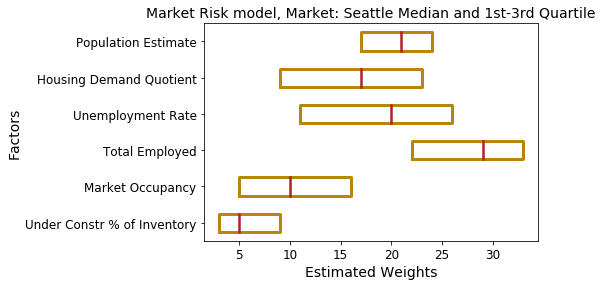

In [13]:
if __name__ == '__main__':
    app.run(host='127.0.0.1',port=5000)